In [1]:
import os
import glob
# import nibabel as nib
import numpy as np
import cv2
# import math
import torch

import matplotlib.pyplot as plt
import plotly.express as px

import sys
sys.path.append('../')
# print(sys.path)
from src.data.data_generator import MRIDataset
from src.utils import plot_tumour

In [2]:
data_path = '../data/all/VS-1-30'
scan_path = os.path.join(data_path, 'vs_gk_11')

In [3]:
t1_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_t1_*')))
t2_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_t2_*')))
seg_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_seg_*')))
print(t1_list)

['../data/all/VS-1-30/vs_gk_1/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_10/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_11/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_12/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_13/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_14/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_15/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_16/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_17/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_18/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_19/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_2/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_20/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_21/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_22/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_23/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_24/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_25/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_26

In [4]:

clicks_dataset = MRIDataset(
    t1_list[2:4], t2_list[2:4], seg_list[2:4],
    (40, 256, 256),
    clicks = {
        'use': True,
        'gen_fg': False,
        'gen_bg': False,
        'gen_border': True,
        'num': 3,
        'dst': 10
    }
)

In [5]:
t1_list[2:4]

['../data/all/VS-1-30/vs_gk_11/vs_gk_t1_refT2.nii.gz',
 '../data/all/VS-1-30/vs_gk_12/vs_gk_t1_refT2.nii.gz']

In [6]:
img, label = clicks_dataset[0]
# click_label = click_label[1].unsqueeze(0)

Tumour indices:  11 27


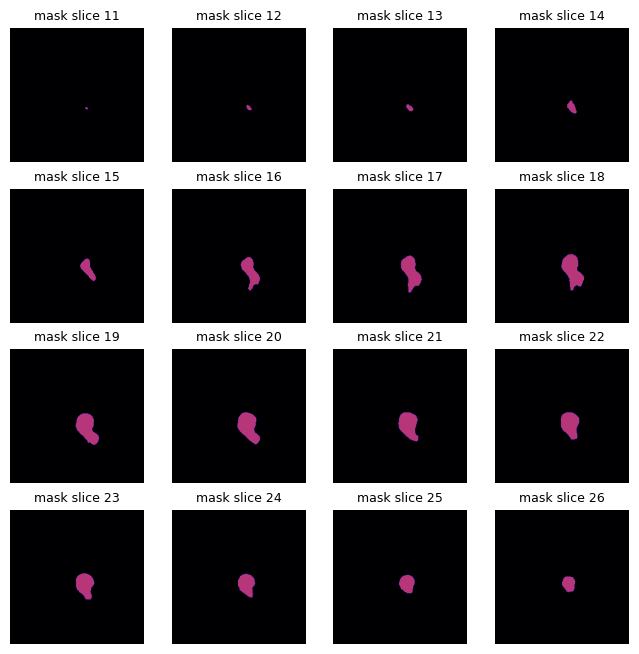

In [7]:
plot_tumour(label[0].unsqueeze(0) + label[1].unsqueeze(0))

### Cuts

In [8]:
def cut_volume(label: torch.Tensor, cut_size=32, num=12, random=False):
    cut_size = cut_size // 2 # needed only as a distance from the center
    
    click_coords = torch.nonzero(label[1])
    # randomize cuts
    if random:
        click_coords = click_coords[torch.randperm(len(click_coords))]
    
    cuts = []
    k = num if len(click_coords) > num else len(click_coords)
    for click_idx in range(0, k):
        coords = click_coords[click_idx]

        # click = torch.zeros_like(label[0][coords[0]])
        # click[coords[1], coords[2]] = 1

        # a = label[0][coords[0]] + click
        cut = torch.clone(label[0][coords[0]])
        # a[coords[1], coords[2]] = 2
        cut = cut[
            coords[1]-cut_size:coords[1]+cut_size,
            coords[2]-cut_size:coords[2]+cut_size
        ]
        cuts.append(cut)
    
    return cuts, click_coords

In [9]:
def plot_cuts(cuts: list[torch.Tensor], cmap='magma'):
    rows = len(cuts)//4
    cols = 4
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0
    
    for i, cut in enumerate(cuts):
        if j >= len(axs): 
            break
        if len(cut.shape) == 3:
            cut = cut.squeeze(0)
        tmp_cut = torch.clone(cut)
        tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 2
        axs[j].imshow(tmp_cut, cmap=cmap)
        axs[j].axis('off')
        axs[j].set_title(f'cut {i}', fontsize=9)
        j += 1

    plt.show()   

In [10]:
def plot_cut(cut, cmap='magma'):
    tmp_cut = torch.clone(cut)
    tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 2
    plt.imshow(tmp_cut, cmap=cmap)

#### Experiments

In [11]:
label.shape

torch.Size([2, 40, 256, 256])

torch.Size([32, 32])

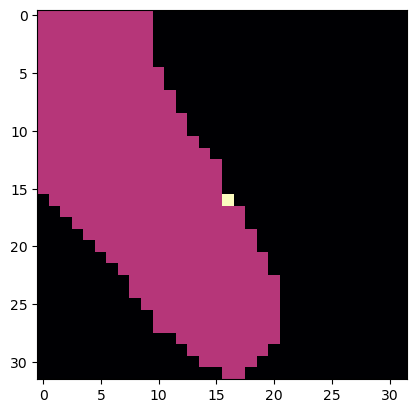

In [12]:
cuts, clicks = cut_volume(label, cut_size=32, num=24)
plot_cut(cuts[10], cmap='magma')
cuts[0].shape

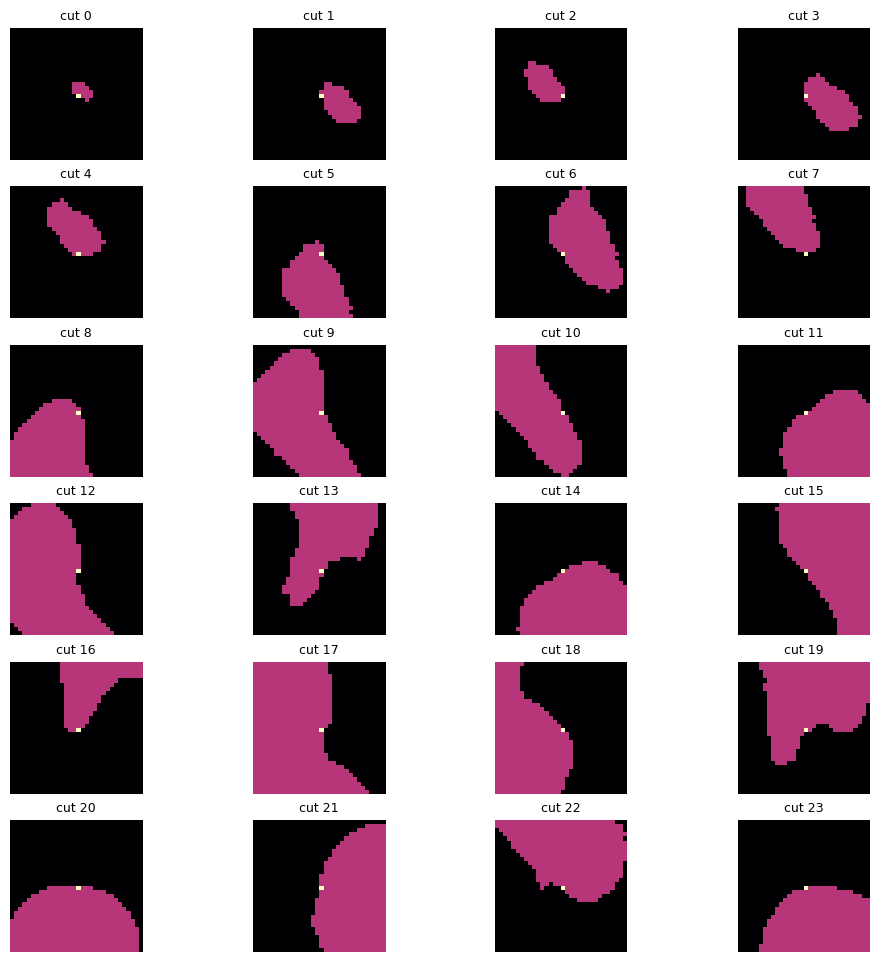

In [13]:
plot_cuts(cuts)

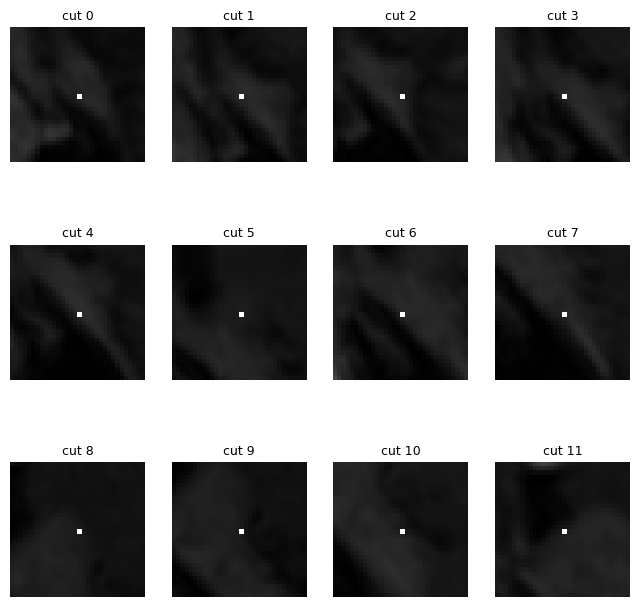

In [14]:
img[1] = label[1]
plot_cuts(cut_volume(img, cut_size=32, num=12)[0], cmap='grey')

In [15]:
cuts, clicks = cut_volume(label, cut_size=32, num=24)
clicks[10]

tensor([ 15, 160, 159])

In [16]:
tmp_cut = torch.clone(cuts[10])
tmp_cut[cuts[0].shape[0]//2, cuts[0].shape[0]//2] = 2
fig = px.imshow(tmp_cut)
fig.show()

### Simulating segmentation errors

In [17]:
from copy import deepcopy

#### 1st try

In [18]:
# TODO: prepisat na diletaciu / eroziu

def simulate_errors(cuts: list[torch.Tensor]):
    faked_cuts = deepcopy(cuts)
    for cut in faked_cuts:
        width = cut.shape[0]
        heigth = cut.shape[1]

        pp = np.random.uniform(low=0.0, high=1.0)

        for x in range(width):
            for y in range(heigth):
                dst = np.linalg.norm([width//2 - x, heigth//2 - y]) 
                p = (dst/(heigth//2)) ** 2
                # print(p, dst)
                
                if 0.5 > pp:
                    if cut[x, y] == 1:
                        if p < np.random.uniform(low=0.0, high=0.6):
                            cut[x, y] = 0

                elif cut[x, y] == 0:
                    if p < np.random.uniform(low=0.0, high=0.6):
                        cut[x, y] = 1
    

    return faked_cuts

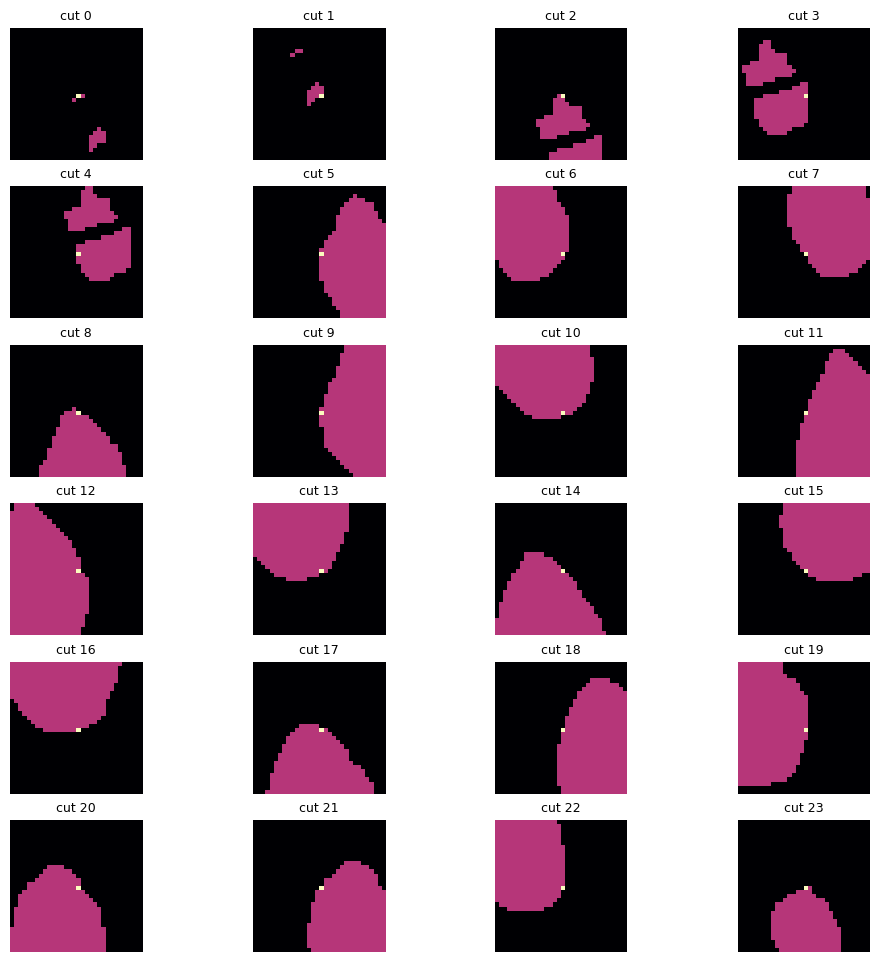

TypeError: simulate_errors() got an unexpected keyword argument 'cut_size'

In [19]:
img, label = clicks_dataset[1]
cuts, clicks = cut_volume(label, cut_size=32, num=24)

plot_cuts(cuts)
plot_cuts(simulate_errors(cuts, cut_size=32, num=24))

#### 2nd try - morphological operations

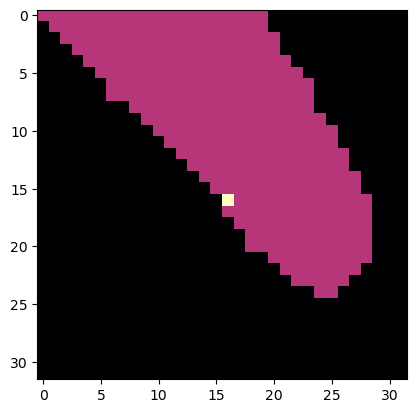

In [11]:
cuts, clicks = cut_volume(label, cut_size=32, num=24)
plot_cut(cuts[10])

In [72]:
def simulate_errors(cuts: list[torch.Tensor]) -> list[torch.Tensor]:
    # cuts, _ = cut_volume(label, cut_size=cut_size, num=num)
    erosion_kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(5, 5))
    dilatation_kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(5, 5))

    faked_cuts = []
    for cut in cuts:
        if len(cut[cut > 0]) < 250:
            iterations = 1
        else:
            iterations = 2

        if len(cut[cut > 0]) < 50:
            cut = cv2.dilate(cut.numpy(), kernel=dilatation_kernel, iterations=1)
        else:
            pp = np.random.uniform(low=0.0, high=1.0)
            if 0.5 > pp:
                cut = cv2.erode(cut.numpy(), kernel=erosion_kernel, iterations=iterations)
            else:
                cut = cv2.dilate(cut.numpy(), kernel=dilatation_kernel, iterations=iterations)
        faked_cuts.append(torch.tensor(cut))

    return faked_cuts

18 0.017578125


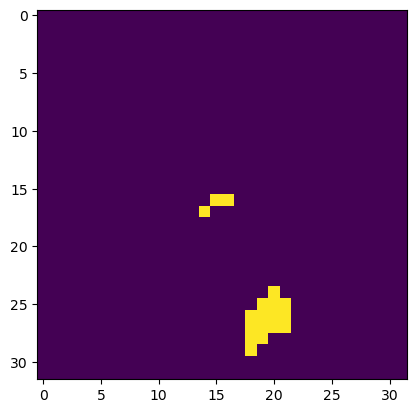

In [73]:
cut_i = 0
plt.imshow(cuts[cut_i])
print(len((cuts[cut_i][cuts[cut_i] > 0])), len((cuts[cut_i][cuts[cut_i] > 0])) / (cuts[cut_i].shape[0] * cuts[cut_i].shape[0]))

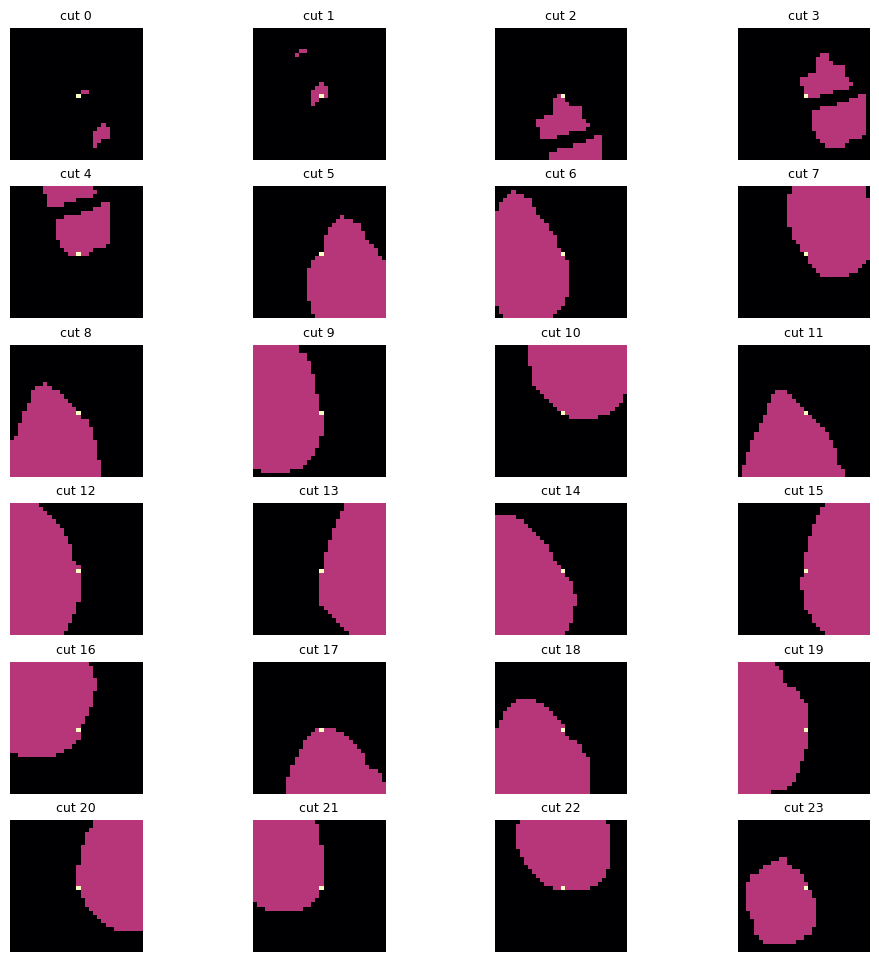

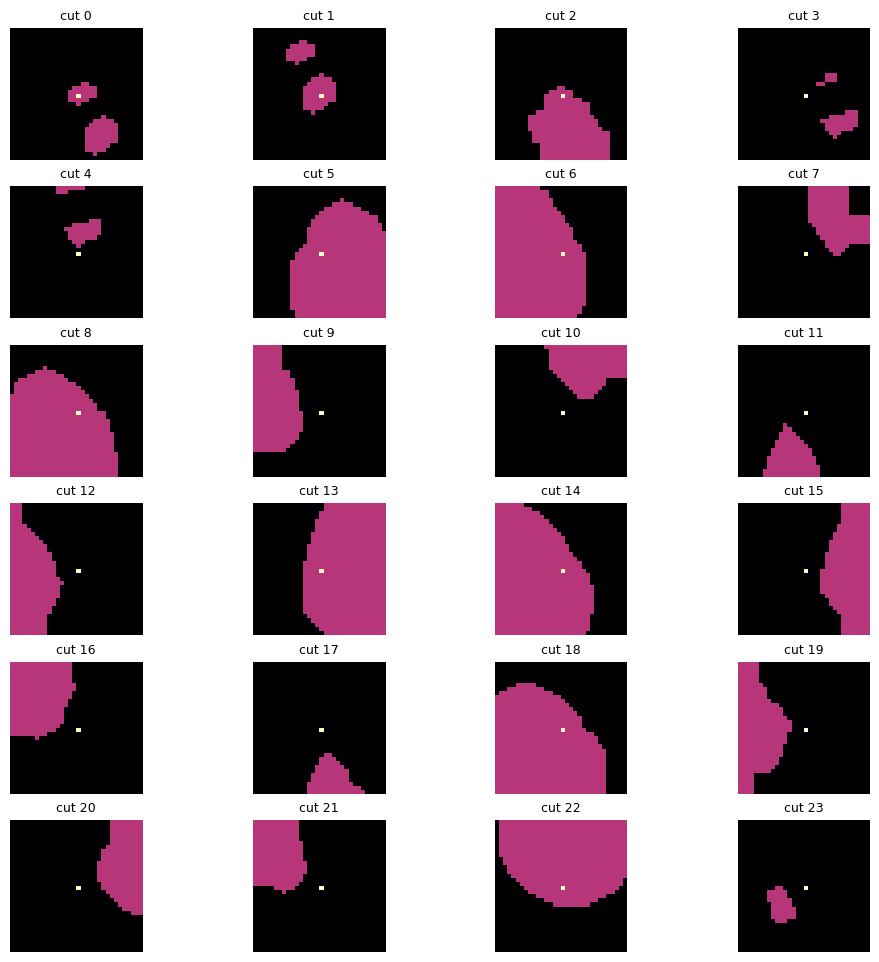

In [74]:
img, label = clicks_dataset[1]
cuts, clicks = cut_volume(label, cut_size=32, num=24)

plot_cuts(cuts)
plot_cuts(simulate_errors(cuts))

#### Using pre-trained model

In [ ]:
from model.segmentation import Unet
# from src.losses.dice import dice_coefficient

In [ ]:
model = Unet(
    in_channels=2, 
    out_channels=1, 
    blocks=3
).to('cpu')

checkpoint = torch.load('../src/models/pretrained_dice_20.pt', map_location='cpu')
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [ ]:
img, y = clicks_dataset[1]

model.eval()
with torch.no_grad():
    x = img.unsqueeze(0).to('cpu')
    y_pred = model(x)

In [ ]:
y_pred.shape

torch.Size([1, 1, 40, 256, 256])

In [ ]:
threshed_pred = torch.clone(y_pred)

In [ ]:
threshed_pred[0,0][threshed_pred[0,0] < 0.6] = 0
threshed_pred[0,0][threshed_pred[0,0] >= 0.6] = 1

In [ ]:
fig = px.imshow(threshed_pred[0,0,17])
fig.show()

In [ ]:
# y_pred[0][y_pred[0] > 0.9] = 1
# plot_tumour(threshed_pred[0])

In [ ]:
# plot_tumour(y)

In [ ]:
pred_cuts, _ = cut_volume(torch.stack((threshed_pred[0,0], label[1])), 10, 24)

6


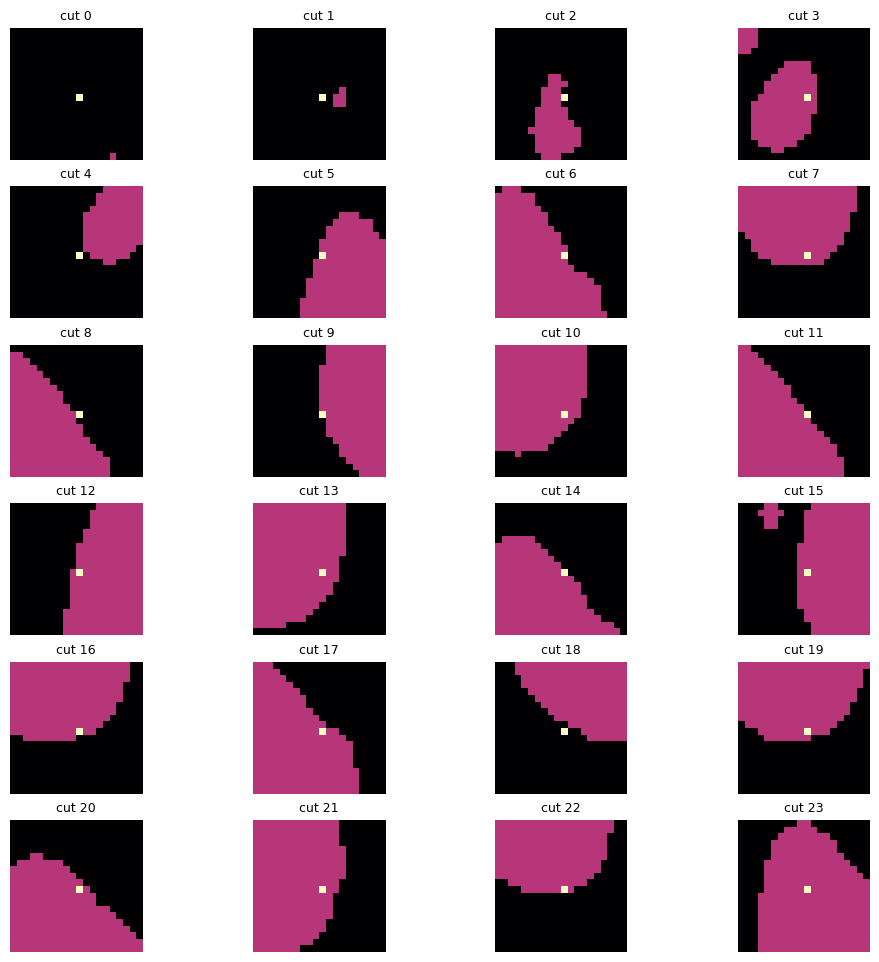

In [ ]:
plot_cuts(pred_cuts)

6


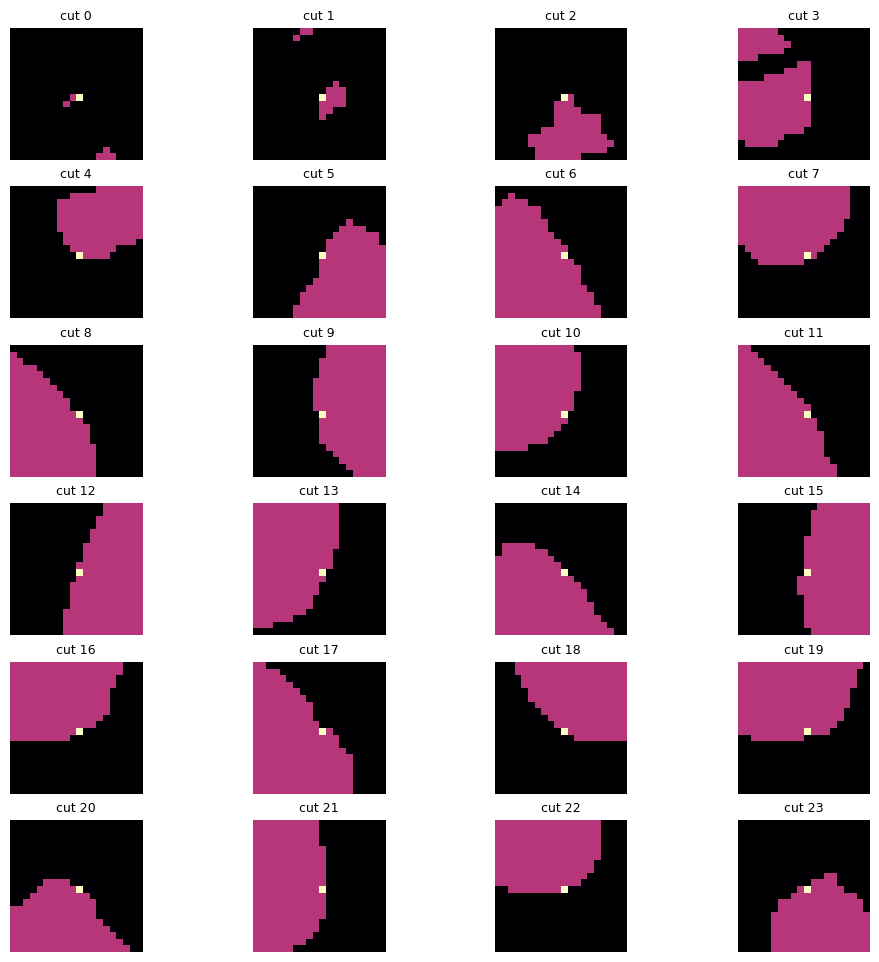

In [ ]:
cc, _ = cut_volume(label, 10, 24)
plot_cuts(cc)

### Testing data generator

In [ ]:
from src.data.correction_generator import CorrectionMRIDataset, CorrectionDataLoader

In [ ]:
data = CorrectionMRIDataset(
    seg_list[:4], 
    (256, 256),
    clicks = {
        'num': 3,
        'dst': 10
    },
    cuts = {
        'num': 12,
        'size': 32,
        'random': False,
    }
)
faked_cuts, cuts = data[2]

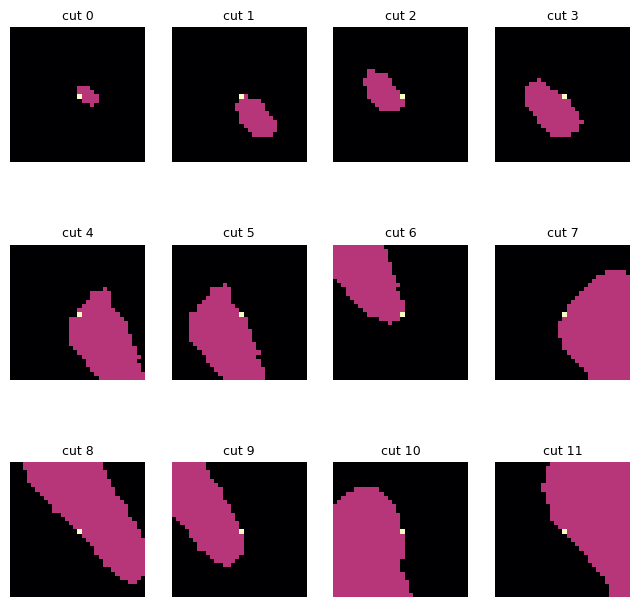

In [ ]:
plot_cuts(cuts)

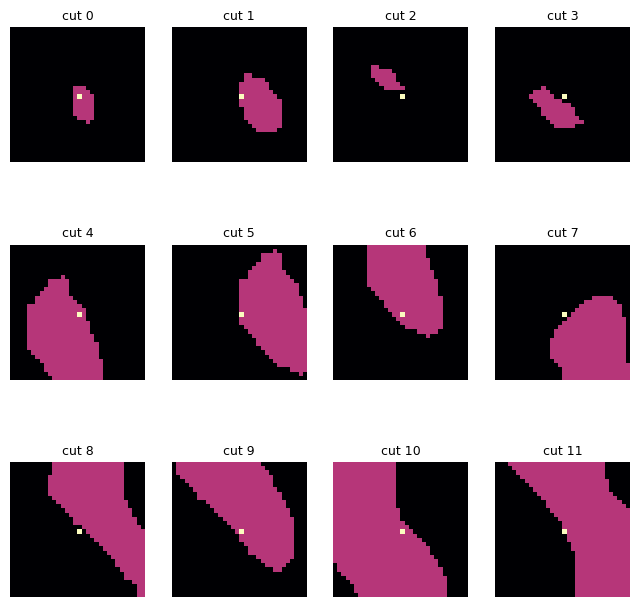

In [ ]:
plot_cuts(faked_cuts)

In [ ]:
def plot_batched_cuts(cuts: torch.Tensor, cmap='magma'):
    rows = len(cuts)//4
    cols = 4
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0
    
    for i in range(cuts.shape[0]):
        if j >= len(axs): 
            break
        tmp_cut = torch.clone(cuts[i,0,:,:])
        tmp_cut[cuts.shape[2]//2, cuts.shape[2]//2] = 2
        axs[j].imshow(tmp_cut, cmap=cmap)
        axs[j].axis('off')
        axs[j].set_title(f'cut {i}', fontsize=9)
        j += 1

    plt.show()   

In [ ]:
dataloader = CorrectionDataLoader(data, 8)
for i, (x, y) in enumerate(dataloader):
    print(i, y.shape)
    # if i == 3:
    #     plot_batched_cuts(y)
    #     plot_batched_cuts(x)
    #     break

0 torch.Size([8, 1, 32, 32])
1 torch.Size([8, 1, 32, 32])
2 torch.Size([8, 1, 32, 32])
3 torch.Size([8, 1, 32, 32])


## Loss

In [30]:
from src.data.correction_generator import CorrectionMRIDataset, CorrectionDataLoader
# from kornia.contrib import distance_transform as kornia_dst
import plotly.express as px
# import cv2
import scipy

In [31]:
data = CorrectionMRIDataset(
    seg_list[:4], 
    (256, 256),
    clicks = {
        'num': 3,
        'dst': 10
    },
    cuts = {
        'num': 12,
        'size': 32,
        'random': False,
    }
)
faked_cuts, cuts = data[2]

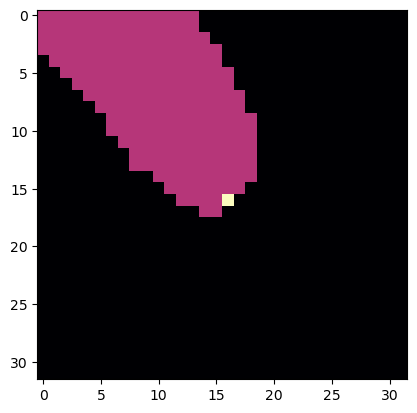

In [32]:
plot_cut(cuts[10][0])

In [33]:
plain = torch.zeros_like(cuts[0])
plain[:,cuts[0].shape[2]//2, cuts[0].shape[2]//2] = 1

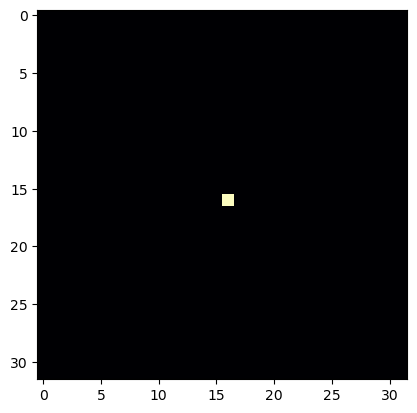

In [34]:
plt.imshow(plain[0], cmap='magma')

In [35]:
# dst_map = kornia_dst(plain.unsqueeze(0))
# fig = px.imshow(dst_map[0,0])
# fig.show()

In [36]:
def get_weight_map(dims: tuple[int], min_thresh=7, max_thresh=20, inverted=False) -> torch.Tensor:   
    tmp = torch.zeros(dims)
    tmp[:, dims[2] // 2, dims[2] // 2] = 1
    dst = scipy.ndimage.distance_transform_edt(1 - tmp[0])

    if inverted:
        weight_map = (1 - dst) + np.abs(np.min(1 - dst))
    else:
        weight_map = dst
    weight_map[weight_map > max_thresh] = max_thresh
    weight_map[weight_map < min_thresh] = min_thresh

    weight_map = weight_map / min_thresh

    return torch.as_tensor(weight_map, dtype=torch.float32).unsqueeze(0)

In [37]:
dst = get_weight_map(cuts[0].shape)
fig = px.imshow(dst[0])
fig.show()

In [38]:
dst = get_weight_map(cuts[0].shape, inverted=True)
fig = px.imshow(dst[0])
fig.show()

In [39]:
a = torch.zeros((2, 1, 32, 32))
(a * dst).shape

torch.Size([2, 1, 32, 32])

In [40]:
a = torch.zeros(1, 32, 32)
b =[torch.stack((a, a)) for i in range(2)]
b[1].shape

torch.Size([2, 1, 32, 32])

In [41]:
cuts[0].shape

torch.Size([1, 32, 32])

In [42]:
torch.sum(cuts[0])

tensor(17.)

In [43]:
torch.sum(torch.stack((cuts[0], cuts[0])), dim=[2, 3])

tensor([[17.],
        [17.]])

Text(0.5, 1.0, 'Cut x Weight Map')

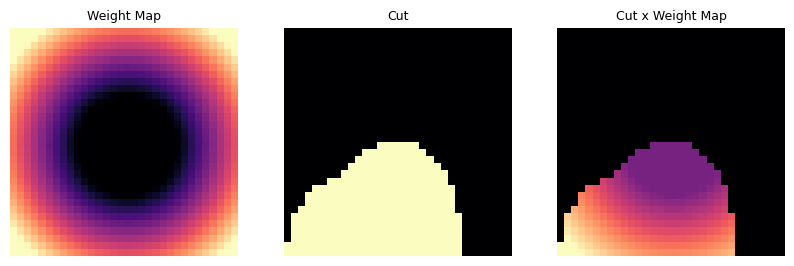

In [64]:
dst = get_weight_map(cuts[0].shape, inverted=False)

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
axs = axs.flatten()
axs[0].imshow(dst[0], cmap="magma")
axs[0].axis('off')
axs[0].set_title("Weight Map", fontsize=9)
axs[1].imshow(cuts[11][0], cmap="magma")
axs[1].axis('off')
axs[1].set_title("Cut", fontsize=9)
axs[2].imshow((cuts[11] * dst)[0], cmap="magma")
axs[2].axis('off')
axs[2].set_title("Cut x Weight Map", fontsize=9)

In [65]:
fig = px.imshow((cuts[11] * dst)[0])
fig.show()

Text(0.5, 1.0, 'faked cut')

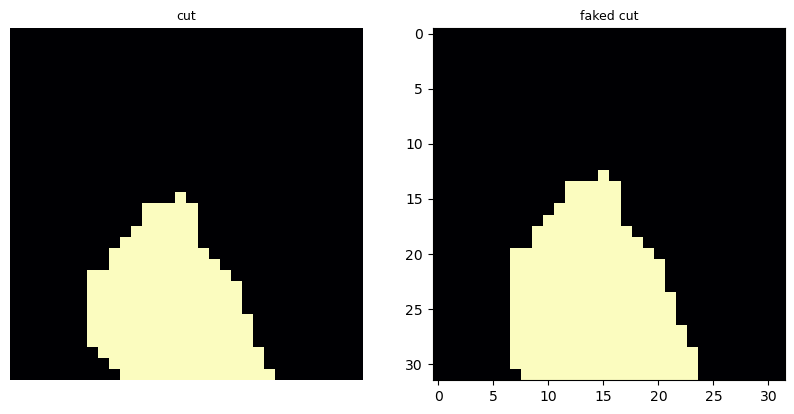

In [66]:
dst = get_weight_map(cuts[0].shape)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.flatten()

axs[0].imshow(cuts[5][0], cmap="magma")
axs[0].axis('off')
axs[0].set_title("cut", fontsize=9)
axs[1].imshow(faked_cuts[5][0], cmap="magma")

axs[1].set_title("faked cut", fontsize=9)

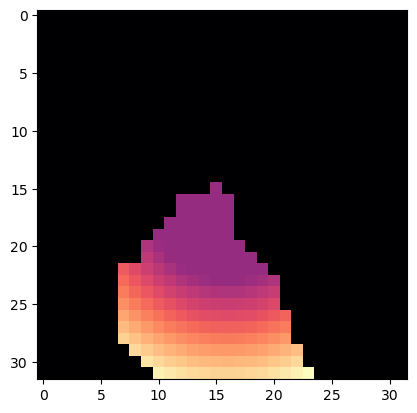

In [67]:
plt.imshow((faked_cuts[5] * cuts[5] * dst)[0], cmap="magma")

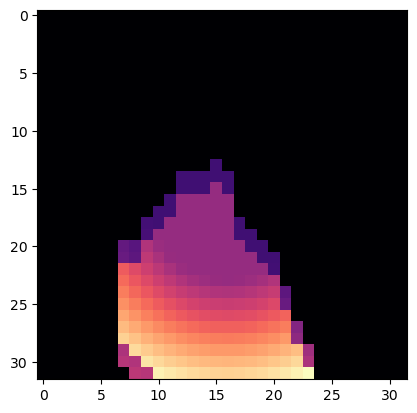

In [68]:
plt.imshow(dst[0] * (faked_cuts[5] + cuts[5])[0], cmap="magma")

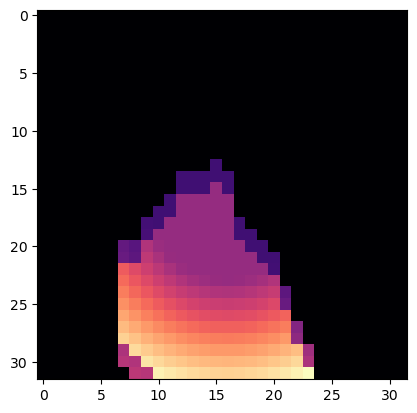

In [69]:
plt.imshow(((faked_cuts[5]*dst) + (cuts[5]*dst))[0], cmap="magma")

In [50]:
y_pred = torch.stack((faked_cuts[5], faked_cuts[6]))
y_true = torch.stack((cuts[5], cuts[6]))
y_pred.shape

torch.Size([2, 1, 32, 32])

In [51]:
dst.shape

torch.Size([1, 32, 32])

In [52]:
torch.sum(dst * (y_pred + y_true), dim=[2, 3])

tensor([[612.1627],
        [903.6893]])

In [53]:
torch.sum((y_pred * dst), dim=[2, 3]) + torch.sum((y_true * dst), dim=[2, 3])

tensor([[612.1627],
        [903.6893]])

In [54]:
def weighted_coefficient(y_pred: torch.Tensor, y_true: torch.Tensor, weight_map: torch.Tensor, eps=1e-6) -> torch.Tensor:
    """ .... """

    # sum for each volume in batch
    intersection = torch.sum(y_pred * y_true * weight_map, dim=[2, 3])
    union = torch.sum(weight_map * (y_pred + y_true), dim=[2, 3])
    # coeff = (intersection + eps) / (union + eps)
    coeff = (2.0 * intersection + eps) / (union + eps)
    
    # mean of the whole batch
    return coeff.mean()

In [55]:
def dice_coefficient2d(y_pred: torch.Tensor, y_true: torch.Tensor, eps=1e-6) -> torch.Tensor:
    """Computes the dice coeff. by summing over the depth, height and width."""

    # sum for each volume in batch
    intersection = torch.sum(y_pred * y_true, dim=[2, 3])
    union = torch.sum(y_pred + y_true, dim=[2, 3])
    dice = (2.0 * intersection + eps) / (union + eps)

    # mean of the whole batch
    return dice.mean()

In [56]:
dice_coefficient2d(y_pred, y_true)

tensor(0.8983)

In [57]:
weighted_coefficient(y_pred, y_true, dst)

tensor(0.8943)

In [2]:
import torch